In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import signal
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

# Get Data and generate spectrograms

In [114]:
song_df = pd.read_hdf('song_df.h5', 'song_df')

In [109]:
plt.ioff()
for i in range(len(song_df.index)):
    a = song_df.iloc[i].Data
    fig, ax = plt.subplots(1, 1, figsize=(0.375*2,0.375*2), frameon=False, facecolor='black')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_facecolor("black")
    #fig.add_axes(ax)
    frequencies, times, spectrogram = signal.spectrogram(a, 16000)
    plt.pcolormesh(np.log(spectrogram))
    plt.axis('off')
    #plt.show()
    filename = song_df.iloc[i].Name + ".png"
    #fig.set_tight_layout(True)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #plt.savefig('/tmp/test.png', bbox_inches=extent)
    fig.savefig("./spectrograms/"+filename, bbox_inches=extent)
    plt.close(fig)

# Log of Spectrogram caused an error because spectrogram values had 0 in sing034_3 due to the pause in between.

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [115]:
song_df.loc[song_df['Name'] == 'sing034_3']

,Name,Data,Freq,Type,MFCC
373,sing034_3,"[-19464192, -16252928, -5177344, 14483456, 465...",16000,0,"[[38.812406955625654, -6.280405806858493, -13...."


# Updating the data repository

In [78]:
import cv2
import copy

In [124]:
spectro_list = []

for i in range(len(song_df.index)):
    filename = "spectrograms/"+song_df.iloc[i].Name+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    spectro_list.append(copy.deepcopy(temp_pic[:, :47]))

In [125]:
song_df['Spectrogram'] = pd.Series(spectro_list, index=song_df.index)

In [126]:
song_df.to_hdf('song_df.h5', key='song_df')

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/pandas-0.23.1-py3.6-linux-x86_64.egg/pandas/core/generic.py:1993: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Name', 'Data', 'MFCC', 'Spectrogram']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# Generating X and y for training

In [120]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [127]:
song_df = pd.read_hdf('song_df.h5', 'song_df')
X = song_df.Spectrogram.values
y = song_df.Type.values

onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y.reshape(len(y), 1))
print(y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [129]:
X_new = np.zeros((1440, 47, 47))
for i,d in enumerate(X):
    X_new[i,:,:] = d[:, :]
print(X_new.shape)
X = X_new

(1440, 47, 47)


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [131]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [132]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1101, 47, 47) (1101, 3)
(195, 47, 47) (195, 3)
(144, 47, 47) (144, 3)


In [133]:
# Saving the generated datasets

# Training set
np.save("./numpy_ds/x_train_conv", X_train)
np.save("./numpy_ds/y_train_conv", y_train)

# Validation set
np.save("./numpy_ds/x_val_conv", X_val)
np.save("./numpy_ds/y_val_conv", y_val)

# Test set
np.save("./numpy_ds/x_test_conv", X_test)
np.save("./numpy_ds/y_test_conv", y_test)

## Loading New dataset

In [134]:
X_train = np.load("./numpy_ds/x_train_conv.npy")
X_val = np.load("./numpy_ds/x_val_conv.npy")
X_test = np.load("./numpy_ds/x_test_conv.npy")

y_train = np.load("./numpy_ds/y_train_conv.npy")
y_val = np.load("./numpy_ds/y_val_conv.npy")
y_test = np.load("./numpy_ds/y_test_conv.npy")

# Model the Convnet

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(3)
torch.manual_seed(0)

In [157]:
class SpectroCNN(nn.Module):
    def __init__(self):
        super(SpectroCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer5 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2)
        self.drop1 = nn.Dropout(p=0.5)
        
        self.activation_layer = nn.ReLU()
        
        self.linear_1 = nn.Linear(1024, 256)
        self.linear_2 = nn.Linear(256, 64)
        self.linear_3 = nn.Linear(64, 16)
        self.linear_4 = nn.Linear(16, 8)
        self.linear_5 = nn.Linear(8, 3)
        
        
    def forward(self, x, dim):

        out = self.conv_layer1(x)
        out = self.activation_layer(out)
        out = self.conv_layer2(out)
        out = self.activation_layer(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer3(out)
        out = self.activation_layer(out)
        out = self.conv_layer4(out)
        out = self.activation_layer(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer5(out)
        out = self.activation_layer(out)
        out = self.maxpool(out)
        
        out = out.view(dim, -1)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        out = self.linear_5(out)
        
        return out

In [186]:
random.seed(0)

def train_cnn(model, x_tr, y_tr, x_v, y_v, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, x_tr.shape[0]), batch_size)
        x = np.zeros((batch_size, 47, 47))
        y = np.zeros((batch_size, 3))
        for i in range(len(selected)):
            x[i, :, :] = x_tr[selected[i]]
            y[i, :] = y_tr[selected[i]]
        dim = batch_size
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 47, 47)
        y = torch.from_numpy(y).long().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, torch.max(y, 1)[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, x_v.shape[0]), 8)
        xv = np.zeros((8, 47, 47))
        yv = np.zeros((8, 3))
        for i in range(len(v)):
            xv[i, :, :] = x_v[v[i]]
            yv[i, :] = y_v[v[i]]
        
        xv = torch.from_numpy(xv).float().cuda()
        xv = xv.view(8, -1, 47, 47)
        yv = torch.from_numpy(yv).long().cuda()      
        
        val_out = model.forward(xv, 8)
        val_out = torch.tensor(val_out).float().cuda()
        v_loss = criterion(val_out, torch.max(yv, 1)[1])
        
        val_losses.append(v_loss.data[0])            
        losses.append(loss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], v_loss.data[0]))
    return losses, val_losses

In [187]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [190]:
epoch_range = 10000
batch_size = 48
learning_rate = 0.0001

cnn_1 = SpectroCNN().cuda()
cnn_1.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate)

losses_1, vloss = train_cnn(cnn_1, X_train, y_train, X_val, y_val, 
                                 criterion, optimizer, epoch_range, batch_size)

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/10000], loss:1.15401, val:1.16896
epoch [101/10000], loss:1.09385, val:1.08859
epoch [201/10000], loss:1.09857, val:1.07943
epoch [301/10000], loss:1.09105, val:1.09324
epoch [401/10000], loss:1.10286, val:1.09709
epoch [501/10000], loss:1.08800, val:1.11538
epoch [601/10000], loss:1.09644, val:1.06216
epoch [701/10000], loss:1.08631, val:1.11605
epoch [801/10000], loss:0.98874, val:1.14352
epoch [901/10000], loss:1.08844, val:0.75468
epoch [1001/10000], loss:0.92682, val:0.71675
epoch [1101/10000], loss:0.96178, val:0.57909
epoch [1201/10000], loss:0.83930, val:0.58681
epoch [1301/10000], loss:0.61165, val:0.76178
epoch [1401/10000], loss:0.84093, val:0.91800
epoch [1501/10000], loss:0.81270, val:0.51144
epoch [1601/10000], loss:0.68488, val:1.25784
epoch [1701/10000], loss:0.52917, val:0.43569
epoch [1801/10000], loss:0.59312, val:0.48309
epoch [1901/10000], loss:0.44112, val:0.53117
epoch [2001/10000], loss:0.55924, val:0.32559
epoch [2101/10000], loss:0.51136, val:0.34736


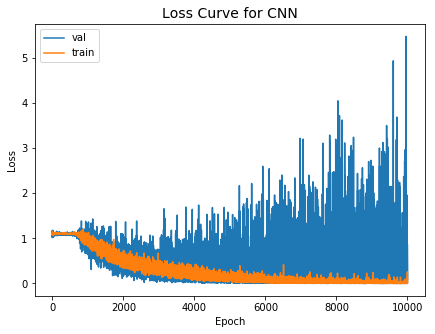

In [194]:
fig = plt.figure(figsize=(7, 5))
plt.title("Loss Curve for CNN", fontsize=14)
plt.plot(vloss, label="val")
plt.plot(losses_1, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig("./images/cnn_performance.pdf", bbox_inches='tight')

In [193]:
total = y_test.shape[0]
correct = 0

for i in range(X_test.shape[0]):
    data = X_test[i, :, :]
    data = torch.from_numpy(data).float().cuda()
    data = data.view(1, -1, 47, 47)
    true_out = y_test[i, :]
    mdl_out = cnn_1.forward(data, 1)
    out = (mdl_out.data).cpu().numpy()
    if np.argmax(out) == np.argmax(true_out):
        correct += 1
print("Accuracy = ", correct*100/total)

Accuracy =  84.72222222222223
